In [1]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

# Camera position optimization using differentiable rendering

In this tutorial we will learn the [x, y, z] position of a camera given a reference image using differentiable rendering. 

We will first initialize a renderer with a starting position for the camera. We will then use this to generate an image, compute a loss with the reference image, and finally backpropagate through the entire pipeline to update the position of the camera. 

This tutorial shows how to:
- load a mesh from an `.obj` file
- initialize a `Camera`, `Shader` and `Renderer`,
- render a mesh
- set up an optimization loop with a loss function and optimizer


##  0. Install and import modules

If `torch`, `torchvision` and `pytorch3d` are not installed, run the following cell:

In [147]:
import os
import torch
import cv2
import numpy as np
from tqdm import tqdm_notebook
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import img_as_ubyte

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes, Textures

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, 
    look_at_view_transform, 
    look_at_rotation, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer, 
    BlendParams,
    SoftSilhouetteShader, 
    HardPhongShader, 
    PointLights
)
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader
)

In [150]:
def show(img):
    plt.imshow(img)

## 1. Load the Obj

We will load an obj file and create a **Meshes** object. **Meshes** is a unique datastructure provided in PyTorch3d for working with **batches of meshes of different sizes**. It has several useful class methods which are used in the rendering pipeline. 

In [116]:
device = torch.device("cuda:0")
torch.cuda.set_device(device)

In [157]:
reference_image = imageio.imread('im.jpg')

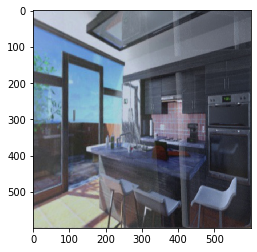

In [158]:
screen_points = [[571, 583], [953, 641], [922, 275], [556, 344]]
segment_end = 600
texture_points = [[0, segment_end], [segment_end, segment_end], [segment_end, 0], [0, 0]]
screen_points = np.array(screen_points, dtype=np.float32)
texture_points = np.array(texture_points, dtype=np.float32)

perspective_transform = cv2.getPerspectiveTransform(screen_points, texture_points)
warped = cv2.warpPerspective(reference_image,perspective_transform,(segment_end, segment_end))
show(warped)

In [177]:
myimg = warped
myimg = np.array(myimg) / 255
myimg = myimg.astype(np.float32)
timg = torch.from_numpy(myimg)
mesh_img = timg.to(device)[None]

In [178]:
# obj_filename = './tv_picture_centered.obj'
# obj_filename = './card_100x100.obj'
# verts, faces_idx, aux = load_obj(obj_filename)
# faces = faces_idx.verts_idx
# verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
# verts_rgb[:,:,2] = 0
# verts_uvs = aux.verts_uvs

In [179]:
import pywavefront
obj_filename = './tv_picture_centered.obj'
vertices = np.array(pywavefront.Wavefront('tv_picture_centered.obj').vertices)

In [180]:
division = 101
facesrow = division - 1

verts = []
verts_uvs = []
faces = []

def verts_coord2idx(x, y):
    return x + y * division

for i, x in enumerate(np.linspace(vertices[0][0], vertices[1][0], division)):
    for j, y in enumerate(np.linspace(vertices[0][1], vertices[2][1], division)):
        texture_x = i / facesrow
        texture_y = j / facesrow
        verts.append([x, y, 0])
        verts_uvs.append([texture_x, texture_y])
for x in range(facesrow):
    for y in range(facesrow):
        faces.append([verts_coord2idx(x, y), verts_coord2idx(x + 1, y), verts_coord2idx(x, y + 1)])
        faces.append([verts_coord2idx(x + 1, y + 1), verts_coord2idx(x + 1, y), verts_coord2idx(x, y + 1)])
verts = np.array(verts, dtype=np.float32)
verts_uvs = np.array(verts_uvs, dtype=np.float32)
        
faces = torch.from_numpy(np.array(faces))
verts = torch.from_numpy(np.array(verts))

In [181]:
faces_torch = torch.from_numpy(np.array([np.array(faces)]))
verts_uvs = torch.from_numpy(np.array([np.array(verts_uvs)]))

In [182]:
# print(faces_torch)
print(faces_torch.shape)
print(faces_torch.dtype)
# print(verts_uvs)
print(verts_uvs.shape)
print(verts_uvs.dtype)
# print(faces)
print(faces.shape)
print(faces.dtype)
# print(verts)
print(verts.shape)
print(verts.dtype)

torch.Size([1, 20000, 3])
torch.int64
torch.Size([1, 10201, 2])
torch.float32
torch.Size([20000, 3])
torch.int64
torch.Size([10201, 3])
torch.float32


If you are running this notebook locally after cloning the PyTorch3d repository, the mesh will already be available. **If using Google Colab, fetch the mesh and save it at the path `data/`**:

In [183]:
textures = Textures(maps=mesh_img, verts_uvs=verts_uvs.to(device), faces_uvs=faces_torch.to(device), 
                    verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
teapot_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)



## 2. Optimization setup

### Create a renderer

A **renderer** in PyTorch3d is composed of a **rasterizer** and a **shader** which each have a number of subcomponents such as a **camera** (orthgraphic/perspective). Here we initialize some of these components and use default values for the rest. 

For optimizing the camera position we will use a renderer which produces a **silhouette** of the object only and does not apply any **lighting** or **shading**. We will also initialize another renderer which applies full **phong shading** and use this for visualizing the outputs. 

In [189]:
cameras = OpenGLPerspectiveCameras(device=device)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to rasterize_meshes.py for explanations of these parameters. 
raster_settings = RasterizationSettings(
    image_size=128, 
    blur_radius=0.0000, 
    faces_per_pixel=1, 
    bin_size=0
)

# Place a point light in front of the object
lights = PointLights(device=device, location=[[1.0, 1.0, -2.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
cow_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

In [190]:
# Initialize an OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device)

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. Refer to rasterize_meshes.py
# for an explanation of this parameter. 
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
    bin_size=0
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    bin_size=0
)
# We can add a point light in front of the object. 
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, lights=lights)
)

### Create a reference image

We will first position the teapot and generate an image. We use helper functions to rotate the teapot to a desired viewpoint. Then we can use the renderers to produce an image. Here we will use both renderers and visualize the silhouette and full shaded image. 

In [194]:
print(image_ref.shape)

(720, 1280, 3)


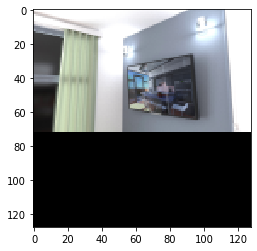

In [222]:
width = 128
height = int(reference_image.shape[0] / reference_image.shape[1] * width)
resized = cv2.resize(reference_image, (width, height), interpolation=cv2.INTER_AREA)
filled = np.hstack(([resized], [np.zeros((width - height, width, 3), dtype=np.uint8)]))[0]
filled = filled / 255
show(filled)

In [223]:
real_distance = 50

(1, 128, 128, 4)
float32


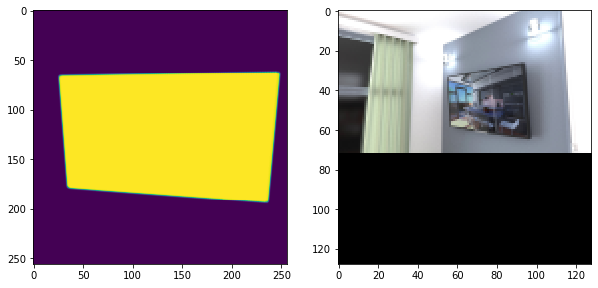

In [224]:
# Select the viewpoint using spherical angles  
distance = real_distance   # distance from camera to the object
elevation = 10.0   # angle of elevation in degrees
azimuth = 10.0  # angle of azimuth rotation in degrees

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Render the teapot providing the values of R and T. 
silhouete = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
image_ref = cow_renderer(meshes_world=teapot_mesh, R=R, T=T)

silhouete = silhouete.cpu().numpy()
image_ref = image_ref.cpu().numpy()
print(image_ref.shape)
print(image_ref.dtype)

image_ref = filled

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouete.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.grid(False)

### Set up a basic model 

Here we create a simple model class and initialize a parameter for the camera position. 

In [244]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer
        
        # Get the silhouette of the reference RGB image by finding all the non zero values. 
        
        image_ref = np.array([image_ref])
        image_ref1 = torch.from_numpy(image_ref.astype(np.float32))
        image_ref2 = torch.from_numpy((image_ref[..., :3].max(-1) != 0).astype(np.float32))
        image_ref = image_ref1
        print(image_ref.dtype)
        print(image_ref.shape)
        print(image_ref2.shape)
        self.register_buffer('image_ref', image_ref)
        
        # Create an optimizable parameter for the x, y, z position of the camera. 
        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([0, 0, -real_distance], dtype=np.float32)).to(meshes.device))
        
        print(self.camera_position)

    def forward(self):
        
        # Render the image using the updated camera position. Based on the new position of the 
        # camer we calculate the rotation and translation matrices
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        
        print(R.shape, T.shape)
        
        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)
        print(image.shape, self.image_ref.shape)
        # Calculate the silhouette loss
        loss = torch.sum((image[:,:,:,:3] - self.image_ref) ** 2)
        return loss, image
  

## 3. Initialize the model and optimizer

Now we can create an instance of the **model** above and set up an **optimizer** for the camera position parameter. 

In [245]:
# We will save images periodically and compose them into a GIF.
filename_output = "./teapot_optimization_demo.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

# Initialize a model using the renderer, mesh and reference image
model = Model(meshes=teapot_mesh, renderer=cow_renderer, image_ref=image_ref).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

torch.float32
torch.Size([1, 128, 128, 3])
torch.Size([1, 128, 128])
Parameter containing:
tensor([  0.,   0., -50.], device='cuda:0', requires_grad=True)


### Visualise the starting position and the reference position

torch.Size([1, 3, 3]) torch.Size([1, 3])
torch.Size([1, 128, 128, 4]) torch.Size([1, 128, 128, 3])


Text(0.5, 1.0, 'Reference silhouette')

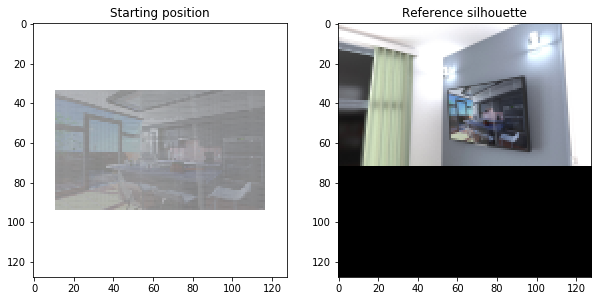

In [246]:
plt.figure(figsize=(10, 10))

_, image_init = model()
plt.subplot(1, 2, 1)
plt.imshow(image_init.detach().squeeze().cpu().numpy())
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference silhouette")


## 4. Run the optimization 

We run several iterations of the forward and backward pass and save outputs every 10 iterations. When this has finished take a look at `./teapot_optimization_demo.gif` for a cool gif of the optimization process!

torch.Size([1, 128, 128, 4]) torch.Size([1, 128, 128, 3])
torch.Size([1, 128, 128, 4]) torch.Size([1, 128, 128, 3])
torch.Size([1, 128, 128, 4]) torch.Size([1, 128, 128, 3])
torch.Size([1, 128, 128, 4]) torch.Size([1, 128, 128, 3])
torch.Size([1, 128, 128, 4]) torch.Size([1, 128, 128, 3])
torch.Size([1, 128, 128, 4]) torch.Size([1, 128, 128, 3])
torch.Size([1, 128, 128, 4]) torch.Size([1, 128, 128, 3])
torch.Size([1, 128, 128, 4]) torch.Size([1, 128, 128, 3])
torch.Size([1, 128, 128, 4]) torch.Size([1, 128, 128, 3])
torch.Size([1, 128, 128, 4]) torch.Size([1, 128, 128, 3])
torch.Size([1, 128, 128, 4]) torch.Size([1, 128, 128, 3])
torch.Size([1, 128, 128, 4]) torch.Size([1, 128, 128, 3])
torch.Size([1, 128, 128, 4]) torch.Size([1, 128, 128, 3])
torch.Size([1, 128, 128, 4]) torch.Size([1, 128, 128, 3])
torch.Size([1, 128, 128, 4]) torch.Size([1, 128, 128, 3])
torch.Size([1, 128, 128, 4]) torch.Size([1, 128, 128, 3])
torch.Size([1, 128, 128, 4]) torch.Size([1, 128, 128, 3])
torch.Size([1,

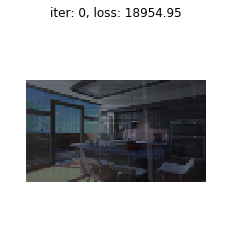

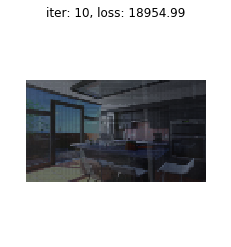

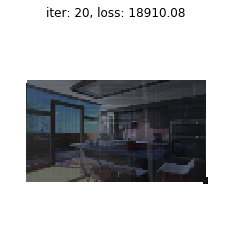

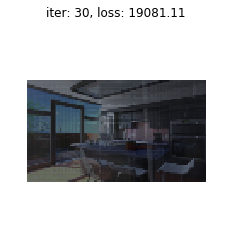

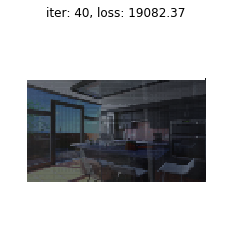

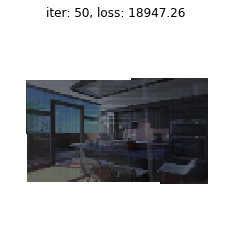

In [234]:
loop = tqdm_notebook(range(51))
for i in loop:
    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()
    
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
    if loss.item() < 200:
        break
    
    # Save outputs to create a GIF. 
    if i % 10 == 0:
        R = look_at_rotation(model.camera_position[None, :], device=model.device)
        T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        image = cow_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        writer.append_data(image)
        
        plt.figure()
        plt.imshow(image[..., :3])
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.grid("off")
        plt.axis("off")
    
writer.close()

## 5. Conclusion 

In this tutorial we learnt how to **load** a mesh from an obj file, initialize a PyTorch3d datastructure called **Meshes**, set up an **Renderer** consisting of a **Rasterizer** and a **Shader**, set up an optimization loop including a **Model** and a **loss function**, and run  the optimization. 